# MIMIC-IV Core Table Analysis
This notebook analyzes the mimic core tables, after they've been transformed to the `mimic_mm_core` view.

In [1]:
# Removes lint errors from VS Code
from typing import Dict, TYPE_CHECKING

if TYPE_CHECKING:
    import kedro
    catalog: kedro.io.data_catalog.DataCatalog
    session: kedro.framework.session.session.KedroSession
    catalog: kedro.io.data_catalog.DataCatalog
    pipelines: Dict[str, kedro.pipeline.pipeline.Pipeline]

# Plotting
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

plt.style.use("./utils/light.mplstyle")
plt.rcParams['figure.figsize'] = [6, 4]
# plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

# Imports
import numpy as np
import pandas as pd

def subplots_row(cols):
    w, h = plt.rcParams['figure.figsize']
    margin = plt.rcParams["figure.subplot.wspace"]
    return plt.subplots(1, cols, figsize=(w*cols + margin*(cols-1), h))


In [2]:
# Load data with kedro
patients = catalog.load('mimic_mm_core.view.patients')
admissions = catalog.load('mimic_mm_core.view.admissions')
transfers = catalog.load('mimic_mm_core.view.transfers')

len(patients), len(admissions), len(transfers)

2000-01-01 00:00:00,000 - kedro.io.data_catalog - INFO - Loading data from `mimic_mm_core.view.patients` (ParquetDataSet)...
2000-01-01 00:00:00,000 - kedro.io.data_catalog - INFO - Loading data from `mimic_mm_core.view.admissions` (ParquetDataSet)...
2000-01-01 00:00:00,000 - kedro.io.data_catalog - INFO - Loading data from `mimic_mm_core.view.transfers` (ParquetDataSet)...


(382278, 523740, 2189535)

## Patients Table Analysis

In [3]:
# Sensitive
patients.head()

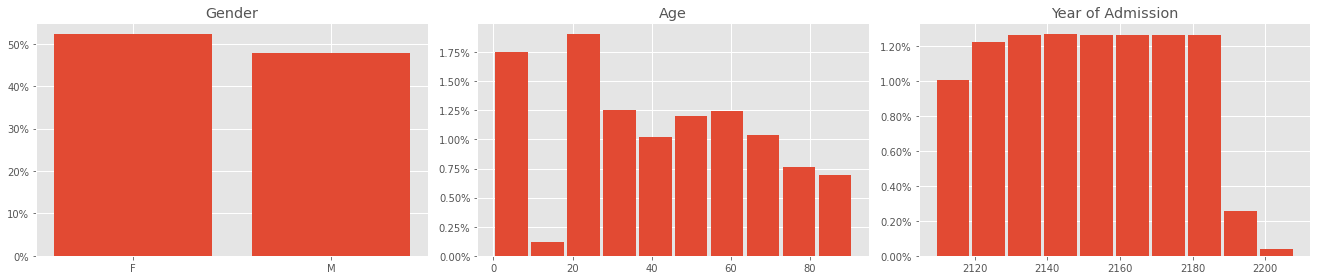

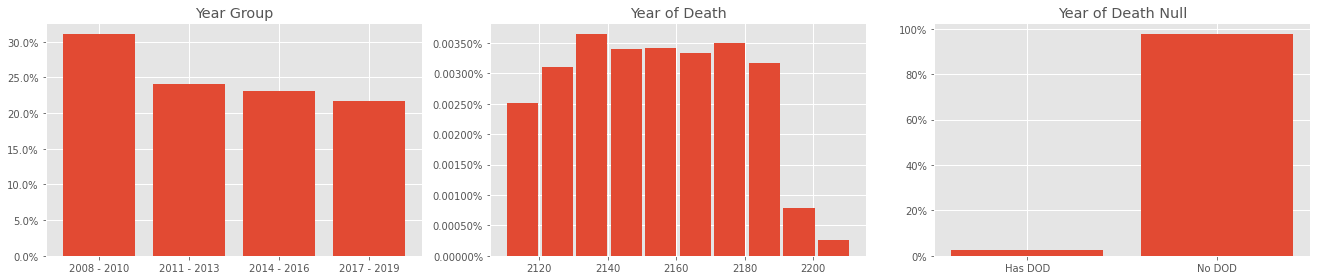

In [4]:
fig, ax = subplots_row(3)
counts = patients.value_counts('gender')
counts /= np.sum(counts)
ax[0].set_title('Gender')
ax[0].bar(list(counts.keys()), list(counts.values))
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) 

ax[1].hist(patients['anchor_age'], density=True, rwidth=0.9)
ax[1].set_title('Age')
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) 

ax[2].hist(patients['anchor_year'], density=True, rwidth=0.9)
ax[2].set_title('Year of Admission')
ax[2].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
fig.tight_layout()

fig, ax = subplots_row(3)
counts = patients.value_counts('anchor_year_group')
counts /= np.sum(counts)
ax[0].set_title('Year Group')
ax[0].bar(list(counts.keys()), list(counts.values))
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) 

ax[1].set_title('Year of Death')
ax[1].hist(patients['dod'].dropna(), density=True, rwidth=0.9)
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) 

total = len(patients)
no_dod = patients['dod'].isnull().sum() / total
ax[2].set_title('Year of Death Null')
ax[2].bar(['Has DOD', "No DOD"], [1-no_dod, no_dod])
ax[2].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
fig.tight_layout()

## Admissions Table Analysis

In [5]:
# Sensitive
admissions.head()

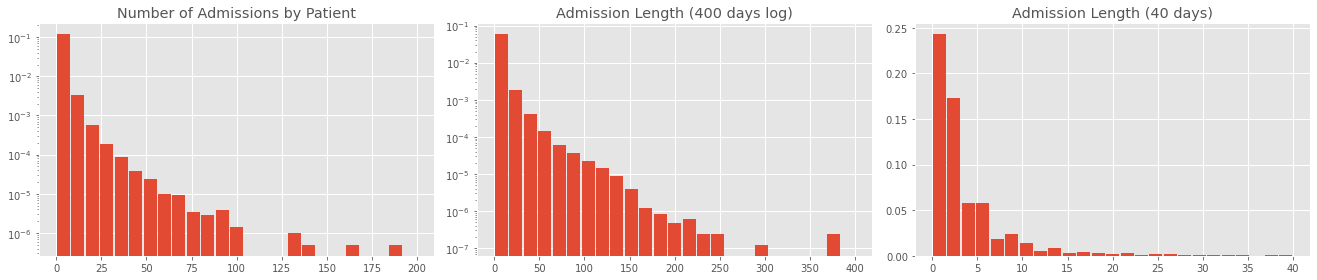

In [27]:
fig, ax = subplots_row(3)
counts = admissions.groupby('subject_id')['subject_id'].count()
ax[0].set_title('Number of Admissions by Patient')
ax[0].hist(counts, range=(0, 200), log=True, density=True, bins=25, rwidth=0.9)

admission_length = admissions['dischtime'] - admissions['admittime']
ax[1].set_title('Admission Length (400 days log)')
ax[1].hist(admission_length.dt.days, range=(0, 400), density=True, log=True, bins=25, rwidth=0.9)

ax[2].set_title('Admission Length (40 days)')
ax[2].hist(admission_length.dt.days, range=(0, 40), density=True, bins=25, rwidth=0.9)

fig.tight_layout()

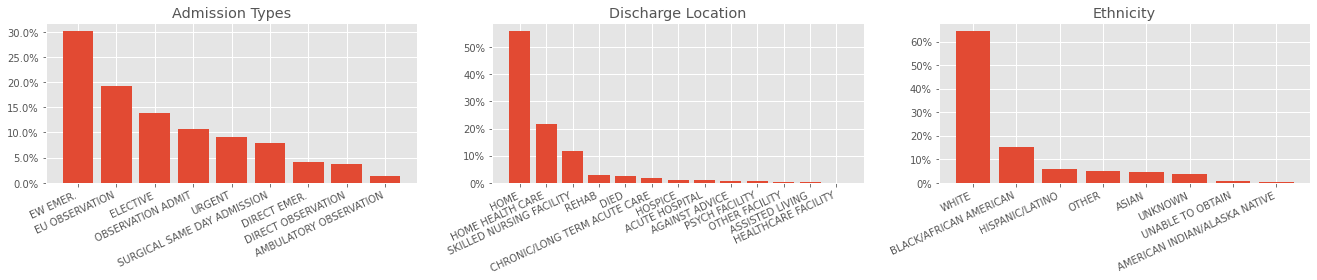

In [40]:
fig, ax = subplots_row(3)
i = 0

counts = admissions.value_counts('admission_type')
counts /= np.sum(counts)
ax[i].set_title('Admission Types')
ax[i].bar(list(counts.keys()), list(counts.values))
ax[i].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.setp(ax[i].get_xticklabels(), rotation=25, horizontalalignment='right')

i += 1
counts = admissions.value_counts('discharge_location')
counts /= np.sum(counts)
ax[i].set_title('Discharge Location')
ax[i].bar(list(counts.keys()), list(counts.values))
ax[i].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.setp(ax[i].get_xticklabels(), rotation=25, horizontalalignment='right')

i += 1
counts = admissions.value_counts('ethnicity')
counts /= np.sum(counts)
ax[i].set_title('Ethnicity')
ax[i].bar(list(counts.keys()), list(counts.values))
ax[i].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.setp(ax[i].get_xticklabels(), rotation=25, horizontalalignment='right')

fig.tight_layout()

In [ ]:
# Sensitive
transfers.head()